In [1]:
!wget https://raw.githubusercontent.com/lnpetrova/deeplearning/main/data.py

--2020-12-27 10:15:41--  https://raw.githubusercontent.com/lnpetrova/deeplearning/main/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10563 (10K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]  10.32K  --.-KB/s    in 0s      

2020-12-27 10:15:42 (61.9 MB/s) - ‘data.py’ saved [10563/10563]



In [2]:
import math
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch import nn
import zipfile
import seaborn as sns
from data import Downloader, Parser
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from statistics import mean
from torch.optim.lr_scheduler import StepLR

#Данные

In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-12-27 10:15:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  11.7MB/s    in 58s     

2020-12-27 10:16:44 (11.3 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [4]:
data_path = 'content'

In [5]:
downloader = Downloader(data_path=data_path)
downloader.run()

multiple: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]


In [6]:
parser = Parser(data_path=data_path)
unlabeled, train, valid = parser.run()

Reading: 100%|██████████| 38/38 [02:51<00:00,  4.52s/it]


In [7]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())

In [8]:
category2index = {category: index for index, category in enumerate(unique_categories)}

In [9]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [10]:
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

### Эмбеддинги

In [11]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [12]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)

In [13]:
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

### Находим оптимальную длину

In [14]:
train_lengths = [len(wordpunct_tokenize(sample)) for sample in tqdm(train_x)]

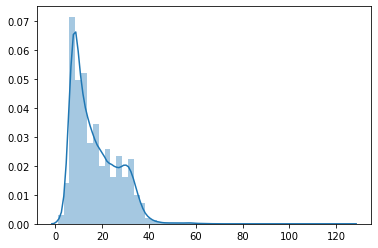

In [15]:
sns.distplot(train_lengths)

In [16]:
np.percentile(train_lengths, 95)

34.0

### Датасет



In [17]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length= None):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index

        self.max_length = max_length
        if not max_length: 
            length = [len(self.tokenization(sample)) for sample in self.texts]
            self.max_length = int(np.percentile(length, 95))
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        tokens = wordpunct_tokenize(text)
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        return token_indices
    
    def padding(self, tokenized_text):
        tokenized_text = tokenized_text[:self.max_length]
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        return tokenized_text
    
    def __getitem__(self, index):
        text = self.texts[index]        
        target = self.targets[index]

        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        tokenized_text = torch.tensor(tokenized_text)
        return tokenized_text, target

In [18]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

### Обучение

In [19]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [43]:
def train_model(train_loader, valid_loader, model, 
                num_epochs, criterion, optimizer, scheduler):
    metrics = defaultdict(list)
    model.train()

    for epoch in range(num_epochs):
        model.train()    
        train_losses =[]
        train_f1s = []

    
        train_progress_bar = tqdm(total=len(train_loader.dataset), desc=f'Epoch: {epoch + 1}, train')

        num_samples = 0 
        for x_train, y_train in train_loader: 
            x_train = x_train.to(device) #Обучать на GPU 2 балла
            y_train = y_train.to(device) #Обучать на GPU
            pred = model(x_train)
            train_loss = criterion(pred, y_train)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(train_loss.item())
            train_f1s.append(f1_score(y_train.cpu(), pred.cpu().argmax(1), average='micro')) #Каждую эпоху рассчитывать метрики 0.25 балла
            #Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций 
            train_progress_bar.set_postfix(train_loss = np.mean(train_losses[-500:]))
            num_samples += x_train.shape[0]
            train_progress_bar.update(num_samples)
            for instance in list(tqdm._instances):
                tqdm._decr_instances(instance)
            train_progress_bar.close()

        metrics['train_loss_i'].extend(train_losses)
        metrics['train_losses'].append(np.mean(train_losses))
        metrics['train_f1_i'].extend(train_f1s)
        metrics['train_f1s'].append(np.mean(train_f1s))

        scheduler.step() #Добавить шедуллер 1 балл
        valid_losses = []
        valid_f1s = []



        valid_progress_bar = tqdm(total=len(valid_loader.dataset), desc=f'Epoch: {epoch + 1}, validation') 

        model.eval()
        for x_valid, y_valid in tqdm(valid_loader):
          x_valid = x_valid.to(device)  
          y_valid = y_valid.to(device)
          with torch.no_grad():
            pred_v = model(x_valid.detach())
            valid_loss = criterion(pred_v, y_valid)
            valid_losses.append(valid_loss.item()) 
            valid_f1s.append(f1_score(y_valid.cpu(), pred_v.cpu().argmax(1), average='micro')) #Каждую эпоху рассчитывать метрики 0.25 балла
            valid_progress_bar.set_postfix(valid_loss = np.mean(valid_losses[-500:]))
            valid_progress_bar.update(x_valid.shape[0])
            for instance in list(tqdm._instances):
                tqdm._decr_instances(instance)
            valid_progress_bar.close()

          #Сохранять лосс на каждой итерции обучения 0.25 балла 
        metrics['valid_loss_i'].extend(valid_losses)
        metrics['valid_losses'].append(np.mean(valid_losses))
        metrics['valid_f1_i'].extend(valid_f1s)
        metrics['valid_f1s'].append(np.mean(valid_f1s))

        print(f"epoch {epoch+1}, train loss {train_loss},train f1 {train_f1s[epoch]}, valid loss {valid_loss}, valid f1 {valid_f1s[epoch]}")
        #Добавить early stopping 0.5 балла
        if epoch > 0 and \
            metrics['train_losses'][-1] < metrics['train_losses'][-2] and \
            metrics['valid_losses'][-1] > metrics['valid_losses'][-2]:
              print('Early stopping')
              break

        

    
    return metrics
    

In [44]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        
        # переводим индексы слов в эмбеддинги этих слов
        # (batch_size, sequence_length) -> (batch_size, sequence_length, embedding_dim)
        x = self.embedding_layer(x)
        
        # агрегируем наши эмбеддинги по размерности время
        # (batch_size, sequence_length, embedding_dim) -> (batch_size, embedding_dim)
        x = x.sum(dim=1)
        
        # делаем нормирование
        # (batch_size, embedding_dim) -> (batch_size, embedding_dim)
        x = self.batch_norm(x)
        
        # прогоняем через первый линейный слой
        # (batch_size, embedding_dim) -> (batch_size, linear_1_size)
        x = self.linear_1(x)
        
        # применяем нелинейность
        # (batch_size, linear_1_size) -> (batch_size, linear_1_size)
        x = torch.relu(x)
        
        # прогоняем через второй линейный слой
        # (batch_size, linear_1_size) -> (batch_size, linear_2_size)
        x = self.linear_2(x)
        
        # применяем нелинейность
        # (batch_size, linear_2_size) -> (batch_size, linear_2_size)
        x = torch.relu(x)
        
        # переводим с помощью линейного преобразования в количество классов
        # (batch_size, linear_2_size) -> (batch_size, n_classes)
        x = self.linear_3(x)
        
        ## по идеи здесь должен был быть софтмакс
        ## но мы будем использовать лосс nn.CrossEntropyLoss()
        ## в его документации написано
        ## This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.
        ## это некоторая оптимизация, которая включает в себя сразу и софтмакс и сам negative log likelihood лосс
        ## так как у нас в лоссе есть софтмакс, то мы не будем применять его в сетке
        ## на этапе предсказания (а не обучения) мы будем отдельно делать софтмакс для получения распределения классов
        ## 
        ## (batch_size, n_classes) -> (batch_size, n_classes)
        # x = torch.softmax(x, dim=-1)
        
        return x

In [45]:
criterion = nn.CrossEntropyLoss()

In [46]:
embeddings = torch.tensor(embeddings).float()
model1 = DeepAverageNetwork(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128, 
                           n_classes=len(category2index))
model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(),lr = 1e-4)
scheduler = StepLR(optimizer, 1, gamma=0.95)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [47]:
model1_res = train_model(train_loader, valid_loader, model1, 4, criterion, optimizer, scheduler)



epoch 1, train loss 1.1582138538360596,train f1 0.078125, valid loss 0.9727913737297058, valid f1 0.6171875




epoch 2, train loss 1.0175113677978516,train f1 0.6640625, valid loss 0.9535114169120789, valid f1 0.5703125




epoch 3, train loss 0.9121010899543762,train f1 0.6640625, valid loss 0.9393174052238464, valid f1 0.65625




epoch 4, train loss 0.8275423645973206,train f1 0.6640625, valid loss 0.9308297038078308, valid f1 0.6328125


In [48]:
#Нарисовать графики лосса, метрик, конфьюжин матрицу 0.5 балла
def plot_f1s(metrics):
    n = len(metrics['train_losses'])
    plt.figure(figsize=(14, 12))
    plt.plot(range(1, n+1), metrics['train_f1s'], c='b', label='Train')    
    plt.plot(range(1, n+1), metrics['valid_f1s'], c='r', label='Test')   
    plt.legend()

In [49]:
def plot_loss(metrics, ):
  n = len(metrics['train_losses'])
  plt.figure(figsize=(14, 12))
  plt.plot(range(1, n+1), metrics['train_losses'], c='b', label='Train') 
  plt.plot(range(1, n+1), metrics['valid_losses'], c='r', label='Test')    
  plt.legend() 
  plt.grid()



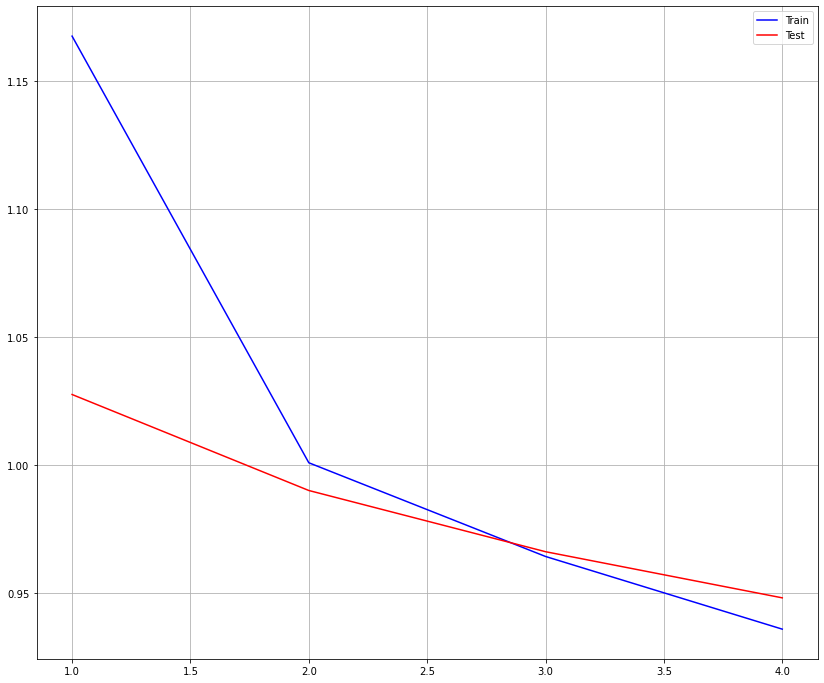

In [50]:
plot_loss(model1_res)

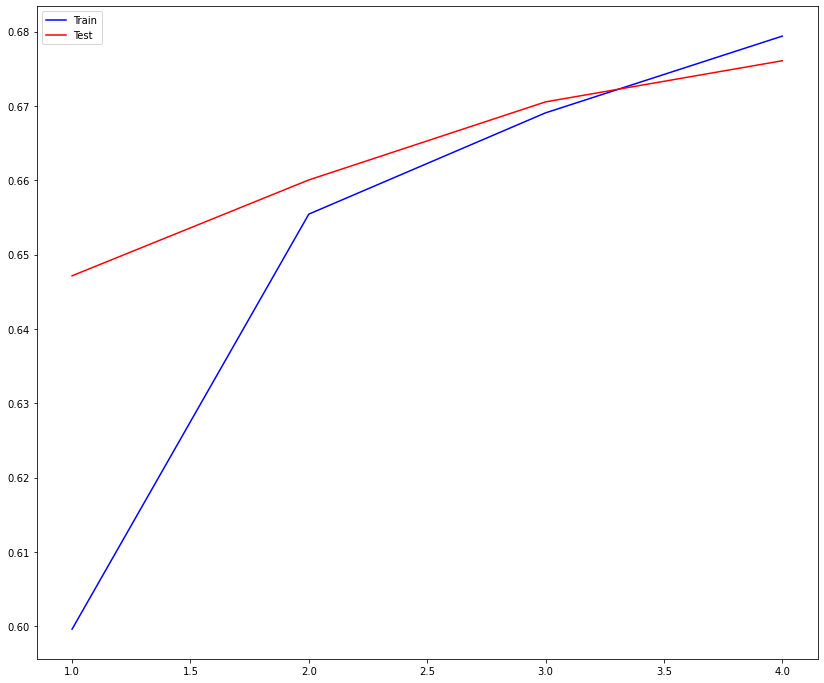

In [51]:
plot_f1s(model1_res)

In [52]:
def plot_confusion(model):
    model.eval()
    y_true, y_pred = [], []
    for x_valid, y_valid in valid_loader:
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        with torch.no_grad():
            forw = model.forward(x_valid)
            pred = torch.softmax(forw, dim=-1)
            y_pred.extend(pred.cpu().argmax(1))
            y_true.extend(y_valid.cpu())

    fig, ax = plt.subplots(figsize=(12,14))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, ax=ax) 

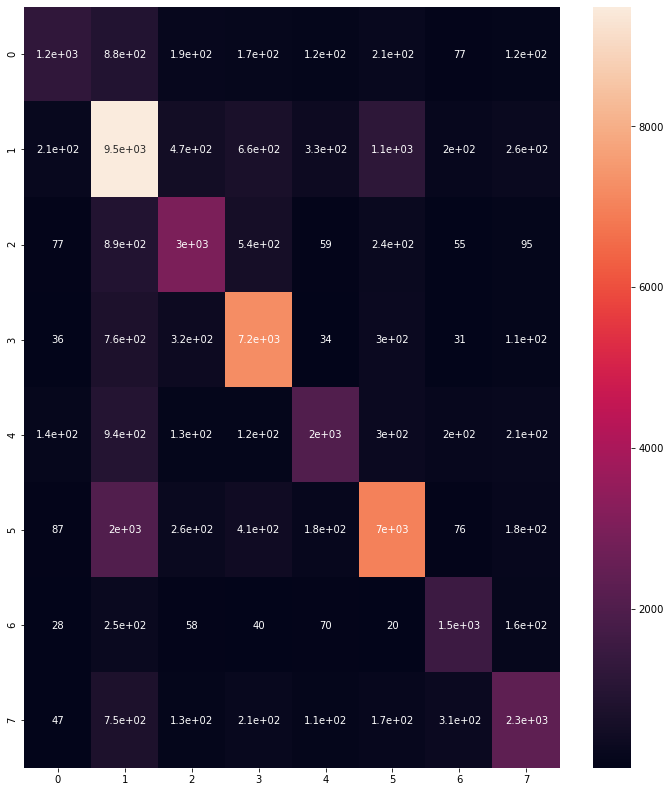

In [53]:
plot_confusion(model1)

### LSTM

In [54]:
#Добавить spatial дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) 1 балл
class SpatialDropout(nn.Dropout2d):
  def __init__(self, p=0.4):
        super().__init__()
        self.p = p

  def forward(self, x):
    x = x.unsqueeze(2)   
    x = x.permute(0, 3, 2, 1)  
    x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
    x = x.permute(0, 3, 2, 1)  
    x = x.squeeze(2)  
    return x

In [55]:
#Добавить torch.nn.utils.rnn.pack_padded_sequence() и torch.nn.utils.rnn.pack_sequence() для LSTM.
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers,
                 bidirectional, dropout, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim1, num_layers=n_layers, bidirectional=True, batch_first=True) #Bidirectional LSTM. 1 балл
        self.h1 = nn.Linear(hidden_dim1 * 2, hidden_dim2)
        self.h2 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=True) 
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        rel = self.relu(cat)
        dense1 = self.h1(rel)
        drop = self.dropout(dense1)
        preds = self.h2(drop)
        return preds

In [56]:
class FirstNetwork(nn.Module):
    
    def __init__(self, embeddings, lstm_size, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0, freeze=False)
        self.embedding_dropout = SpatialDropout()
        self.layer_norm = nn.LayerNorm(normalized_shape=lstm_size*2)
        self.lstm = nn.LSTM(input_size=embeddings.shape[-1], hidden_size=lstm_size, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
        self.linear_1 = nn.Linear(in_features=lstm_size*2, out_features=linear_1_size) 
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.output = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.embedding_dropout(x)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.layer_norm(x)
        x = self.linear_1(x)        
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        x = self.output(x)
                
        return x

In [57]:
embeddings = torch.tensor(embeddings).float()
model = FirstNetwork(embeddings=torch.tensor(embeddings).float(),
                    lstm_size=256,
                    linear_1_size=256, 
                    linear_2_size=128, 
                    n_classes=len(category2index))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
scheduler = StepLR(optimizer, 1, gamma=0.95)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [58]:
lstm_results = train_model(train_loader, valid_loader, model, 4, criterion, optimizer, scheduler)



epoch 1, train loss 1.0695189237594604,train f1 0.0625, valid loss 0.8626914024353027, valid f1 0.6328125




epoch 2, train loss 1.062595009803772,train f1 0.7265625, valid loss 0.8480939865112305, valid f1 0.6328125




epoch 3, train loss 0.8542057871818542,train f1 0.65625, valid loss 0.8422461748123169, valid f1 0.703125




epoch 4, train loss 0.9031971096992493,train f1 0.7734375, valid loss 0.8388840556144714, valid f1 0.734375


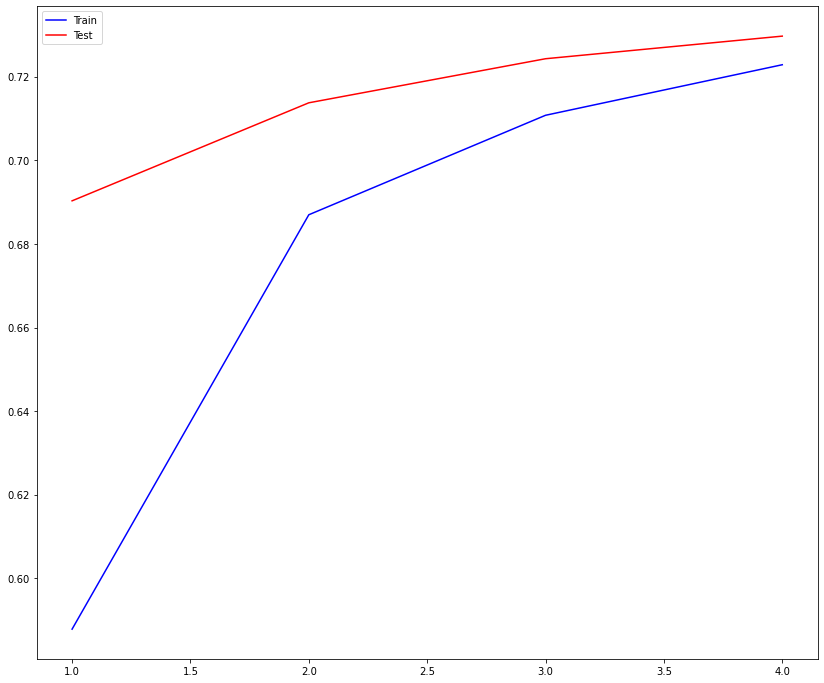

In [59]:
plot_f1s(lstm_results)

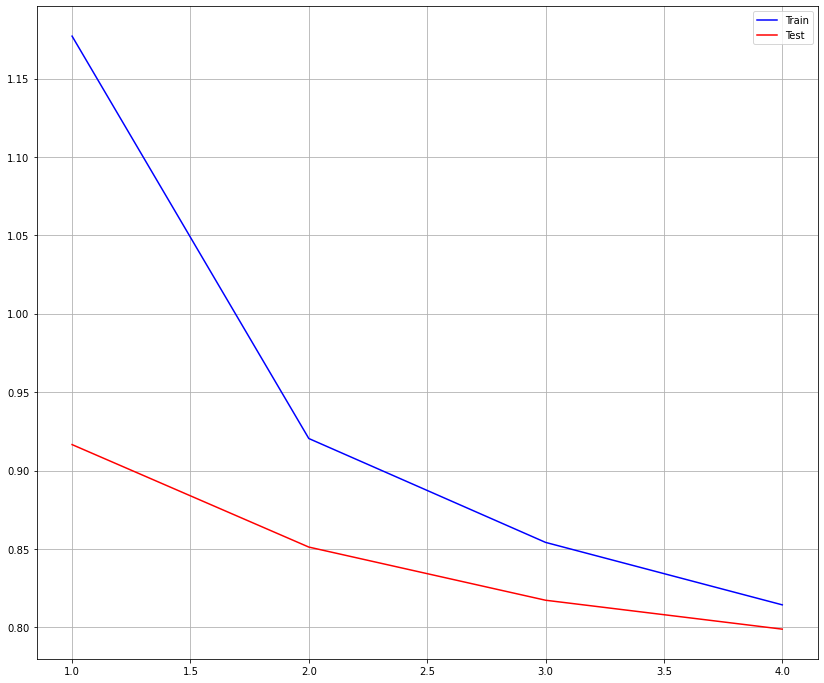

In [60]:
plot_loss(lstm_results)

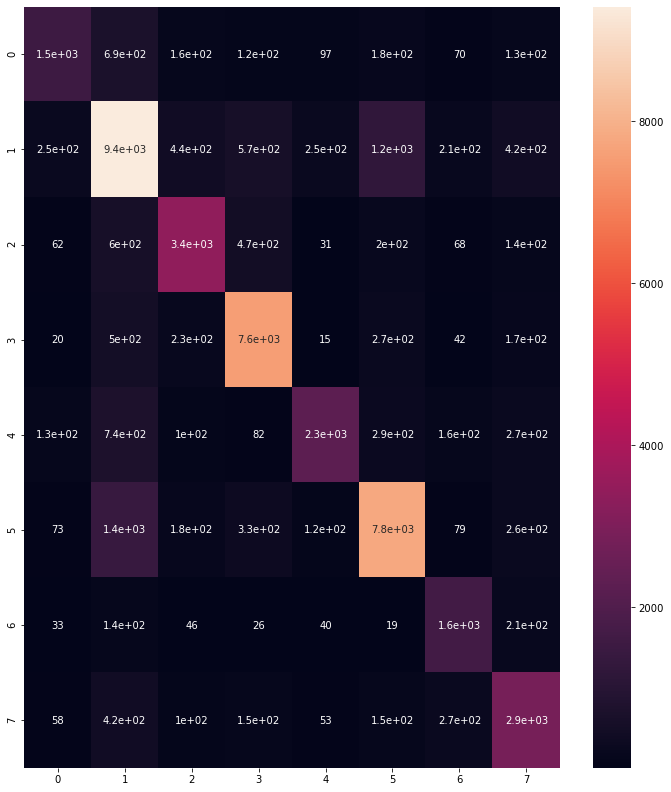

In [61]:
plot_confusion(model)

### CNN

In [62]:
class CNNNetwork(nn.Module):
  def __init__(self, embeddings, conv_1_size, conv_2_size, linear_1_size, linear_2_size, n_classes):
    super().__init__()
    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0) 
    self.conv1 = nn.Conv1d(in_channels=embeddings.shape[-1], out_channels=conv_1_size, kernel_size=2, padding=1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv1d(in_channels=conv_1_size, out_channels=conv_2_size, kernel_size=2,  padding=1)
    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1]) #Добавить BatchNorm/LayerNorm/Dropout/Residual/etc 1 балл
    self.dropout = nn.Dropout(p=0.5)
    self.linear_1 = nn.Linear(in_features=conv_2_size, out_features=linear_1_size)
    self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
    self.output = nn.Linear(in_features=linear_2_size, out_features=n_classes)
    
  def forward(self, x):
    x = self.embedding_layer(x)
    x = x.permute(0, 2, 1)
    #print("my shape", x.shape)
    x = self.conv1(x)
    x = torch.max_pool1d(x, kernel_size=3)
    x = self.relu(x)
    x = self.conv2(x)
    #print("my shape conv2", x.shape)
    x = x.sum(dim=2)
    #print("my shape", x.shape)
    x = self.linear_1(x)
    x = torch.relu(x)
    x = self.linear_2(x)
    x = self.dropout(x)
    x = torch.relu(x)
    # print(x.size())
    # print(y.size())
    x = self.output(x)
    return x

In [63]:
model_cnn = CNNNetwork(embeddings=torch.tensor(embeddings).float(),
                   conv_1_size = 128,
                   conv_2_size = 64,
                   linear_1_size=128, 
                   linear_2_size=64, 
                   n_classes=len(category2index))
model_cnn.to(device)

optimizer = torch.optim.Adam(model_cnn.parameters(),lr = 1e-4)
scheduler = StepLR(optimizer, 1, gamma=0.95)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [64]:
cnn_results = train_model(train_loader, valid_loader, model_cnn, 4, criterion, optimizer, scheduler)



epoch 1, train loss 1.2697389125823975,train f1 0.15625, valid loss 0.9998024106025696, valid f1 0.5703125




epoch 2, train loss 1.1146296262741089,train f1 0.71875, valid loss 0.9160951375961304, valid f1 0.546875




epoch 3, train loss 0.9393302202224731,train f1 0.640625, valid loss 0.8888090252876282, valid f1 0.65625




epoch 4, train loss 0.6990587711334229,train f1 0.7265625, valid loss 0.8944479823112488, valid f1 0.65625


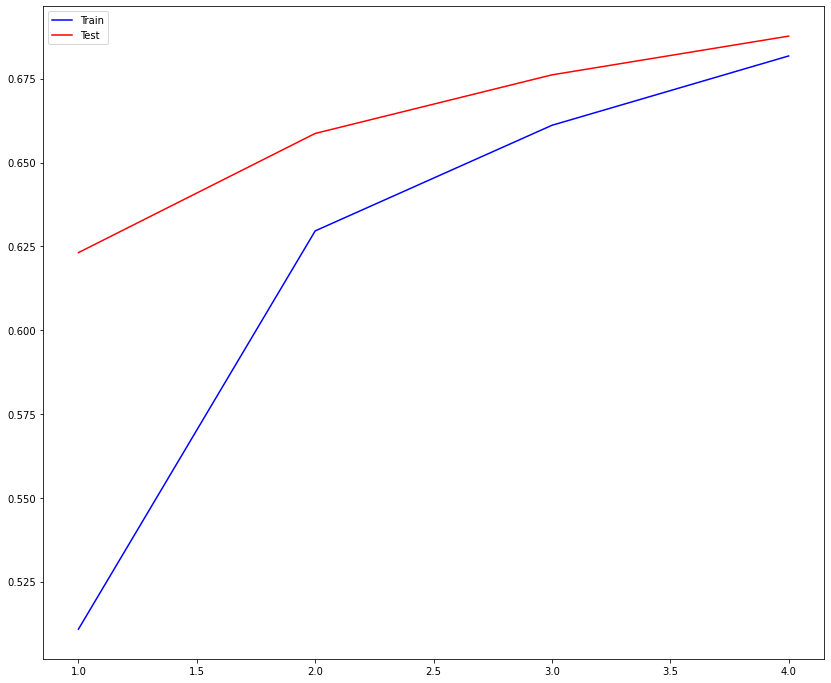

In [65]:
plot_f1s(cnn_results)

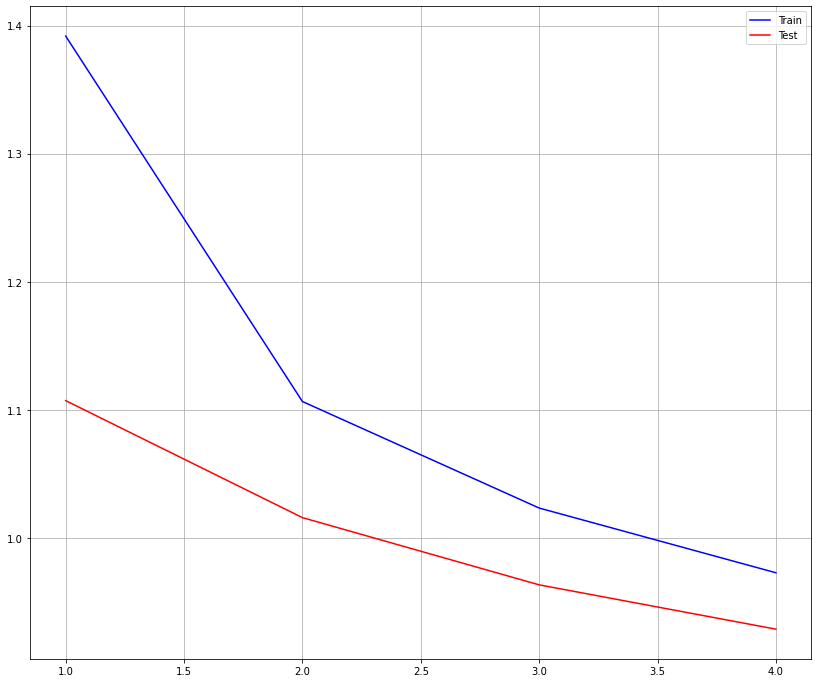

In [66]:
plot_loss(cnn_results)

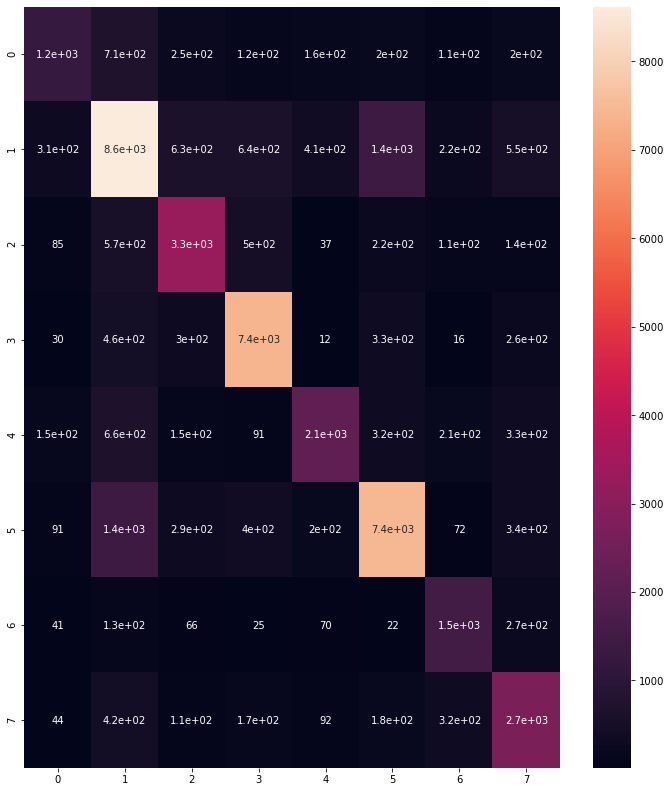

In [67]:
plot_confusion(model_cnn)

# CNN 2

In [68]:
class ParallelCNN(nn.Module):
    def __init__(self, embeddings,n_classes):

        super().__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        self.cnn1 = nn.Sequential(
            nn.Conv1d(in_channels=embeddings.shape[-1], out_channels=128, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=3, padding=1),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=3, padding=1))

        self.cnn2 = nn.Sequential(
            nn.Conv1d(in_channels=embeddings.shape[-1], out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=5, padding=2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=5, padding=2))

        self.cnn3 = nn.Sequential(
            nn.Conv1d(in_channels=embeddings.shape[-1], out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=3, padding=1),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=3, padding=1),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=3, padding=1))

        self.dropout = nn.Dropout(p=0.5)

        self.linear_1 = nn.Linear(in_features=64+32+32, out_features=64)
        self.linear_2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=n_classes)


    def forward(self, x):
        x = self.embedding_layer(x)
#         print(x.shape)
        x = x.transpose(1,2)
#         print(x.shape)
        res1 = self.cnn1(x).mean(dim=2)
        res2 = self.cnn2(x).mean(dim=2)
        res3 = self.cnn3(x).mean(dim=2)
        x = torch.cat([res1, res2, res3], dim=1)
        x = self.dropout(x)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        return self.output(x)


In [69]:
model_cnn2 = ParallelCNN(embeddings=torch.tensor(embeddings).float(),
                   n_classes=len(category2index))
model_cnn2.to(device)
optimizer = torch.optim.Adam(model_cnn2.parameters(),lr = 1e-4)
scheduler = StepLR(optimizer, 1, gamma=0.95)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [ ]:
cnn_results2 = train_model(train_loader, valid_loader, model_cnn2, 4, criterion, optimizer, scheduler)



epoch 1, train loss 1.2435054779052734,train f1 0.0390625, valid loss 1.214029312133789, valid f1 0.4296875


In [ ]:
plot_f1s(cnn_results2)

In [ ]:
plot_loss(cnn_results2)

In [ ]:
plot_confusion(model_cnn2)